<a href="https://colab.research.google.com/github/u-keigo/RRIproject1/blob/main/LSTM_hurst2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ハースト指数を予測する
## （失敗作）

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
import os
from glob import glob
import pandas as pd
import linecache


def read_Gauss(name):
  nums = []  # 整数を入れるリスト
  with open(name, 'r', encoding='utf-8') as fin:  # ファイルを開く
    for line in fin.readlines():  # 行を読み込んでfor文で回す
        try:
            line = line.replace('\n','')
            num = float(line)  # 行を整数（int）に変換する
        except ValueError as e:
            print(e, file=sys.stderr)  # エラーが出たら画面に出力
            continue

        nums.append(num)  # 変換した整数をリストに保存する
  return (nums)


# カテゴリを配列で取得
drive_dir = "/content/drive/My Drive/python/"

categories = [name for name in os.listdir(drive_dir + 'data_gauss') if os.path.isdir(drive_dir + "data_gauss/" +name)]
print(categories)

# datasets = pd.DataFrame(columns=["data", "hurst"])
# for cat in categories:
#     path = drive_dir + "data_gauss/" + cat + "/*.rri"
#     files = glob(path)
#     for text_name in files:
#       data = pd.DataFrame(read_Gauss(text_name)).T  # 転置
#       s = pd.Series([data, cat], index=datasets.columns)
#       datasets = datasets.append(s, ignore_index=True)


['H=0.1', 'H=0.9', 'H=0.7', 'H=0.8', 'H=0.6', 'H=0.5', 'H=0.4', 'H=0.3', 'H=0.2']


In [18]:
import numpy as np
DAT = pd.DataFrame(np.zeros(shape=(1024, (32*9))))
i=0
for cat in categories:
    path = drive_dir + "data_gauss/" + cat + "/*.rri"
    files = glob(path)
    for text_name in files:
      data = pd.Series(read_Gauss(text_name))
      DAT.iloc[:, i] = data
      DAT.rename(columns={i: cat}, inplace=True)
      i = i+1
# print(DAT)

# データフレームシャッフル
# datasets = datasets.sample(frac=1).reset_index(drop=True)
# datasets.head()

# データフレームシャッフル
DAT = DAT.sample(frac=1,axis=1).reset_index(drop=True)
# DAT.head()
DAT.T.head()

# DAT = DAT.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999,1000,1001,1002,1003,1004,1005,1006,1007,1008,1009,1010,1011,1012,1013,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
H=0.8,1.081220,-0.466223,0.448821,-0.270061,0.955563,-0.132322,1.026051,0.428904,-0.877347,-0.252242,1.141460,1.012073,0.270662,0.672422,-0.614371,0.316036,0.990671,-0.220835,-0.123766,-0.288017,0.599795,0.413915,1.438428,1.694147,1.570087,2.009134,1.707526,1.797674,0.802184,0.898621,0.665646,-0.950622,0.065790,-0.657510,-0.448334,0.379653,0.682335,0.322825,0.530928,-0.493479,...,0.473240,0.169879,-0.050818,0.264690,0.829137,-0.254991,-0.366313,1.003994,0.857811,-1.373315,0.208462,-0.723135,0.260181,-1.313718,0.283033,-0.700299,-0.945350,-0.480835,0.248203,0.021129,-1.026322,0.259089,-0.818444,-0.723609,-1.530818,-1.444361,-1.356688,-0.868234,-0.760057,0.378079,-0.590334,-0.880650,0.918100,-0.995229,0.180448,-0.276451,-0.126465,-1.100336,-0.796695,-0.366983
H=0.2,2.349821,-1.098292,0.206474,-0.699417,-0.979692,1.185743,-1.353455,0.197714,-0.455217,0.819474,0.853858,-1.134331,0.189728,0.670844,0.360995,0.223842,0.295898,-0.467135,0.305479,0.533374,-0.182241,-0.761533,0.496710,-1.205217,-0.414505,0.732610,0.906869,-0.969266,-0.545976,1.172338,-0.810165,-0.477207,0.379367,2.142363,-1.030570,-0.138550,-0.837162,0.783635,-1.677740,1.578123,...,-0.979011,1.047802,-0.396257,0.625490,-1.216494,0.025856,1.122956,-0.580375,-1.829485,0.445813,2.360200,-2.184127,2.371423,0.063979,0.243639,0.037973,0.257532,0.932046,-0.191536,1.107596,-0.836854,-0.734388,0.841930,-2.728639,1.394709,-0.500120,0.349409,0.170111,0.339199,-0.738828,-0.093201,-0.129033,-0.363034,0.336361,-1.547395,1.749766,0.407874,-0.493725,0.550379,0.506152
H=0.9,1.318264,0.853099,1.176719,-0.096603,0.032307,-0.004347,-0.306752,-0.301542,0.557565,-0.118395,-0.433116,-0.269064,-1.417738,-1.288668,-1.249530,-0.285020,-0.041512,-0.304697,-0.500136,0.175904,0.455460,0.376668,0.403881,1.372776,1.032165,-0.038328,-0.087098,0.522925,0.209257,0.553176,-0.312711,-0.243420,0.063152,-0.472047,-0.382859,-0.408662,-0.604408,-0.612729,0.217037,-1.016204,...,1.088469,1.211031,1.649463,1.366937,1.215562,0.521412,0.729830,0.363814,0.149953,-0.297791,0.512051,0.241238,0.280507,-0.378437,0.097900,0.448632,-0.176819,0.181371,-0.368593,0.551827,0.336692,0.299602,-0.167670,0.712639,0.120785,-0.328219,-0.063728,-0.186684,0.563453,0.436234,1.133757,0.860582,1.233934,0.210437,-0.423220,-0.839056,-0.195591,-0.476278,-0.534649,0.942192
H=0.9,-1.377474,-0.524521,-1.390828,-2.331807,-1.824477,-1.395063,-1.539889,-1.743832,-2.067304,-1.234445,0.037610,-0.233607,-1.463204,-0.842157,-1.376860,-0.827061,-1.290072,-1.149924,-1.106254,-1.448530,-1.793017,-0.512032,-1.100220,-1.797649,-0.772432,-1.062906,-0.210246,-1.349159,-0.494662,-1.663152,-0.726361,-1.186176,0.903329,0.235523,-0.388771,-0.611115,-0.628022,-0.790578,-0.983201,-1.619559,...,-1.438244,-1.365152,-0.788250,-0.084149,0.211608,-1.951193,-1.502755,-1.064303,-1.621049,-1.432032,-2.590128,-2.378314,-2.405253,-1.691840,-1.804896,-1.168007,-1.165539,-1.415047,-0.154842,-0.649902,-1.360119,-0.147231,-1.608744,-1.906187,-0.054851,-0.571294,-0.720339,-1.316556,-1.119316,-0.340377,-0.624661,-0.962480,-0.321520,-1.302981,0.782560,-0.336910,-1.822888,-0.504277,-0.483810,-0.767977
H=0.4,-0.780532,0.115989,0.208394,0.385630,1.422088,-0.341390,-0.483914,0.114750,1.045467,-1.242310,-0.943463,1.891369,-0.675751,2.255156,-0.203973,-0.486299,-0.470503,0.297299,0.402749,1.972319,-0.072595,-0.822167,-0.965147,0.999454,-0.739039,-0.741960,0.282054,-1.561822,-0.631089,1.435976,-0.067428,0.666723,-0.226097,-0.390372,0.071125,1.181393,1.685137,0.231603,-0.882087,-0.533814,...,0.009644,0.220131,0.990605,0.195405,2.460764,-0.245678,-0.737297,1.096164,-1.255314,0.464159,-0.651257,-0.486440,-1.750244,-1.010852,0.217587,0.950562,-0.062550,0.010344,0.596334,0.526791,-0.051222,0.5837

In [19]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import TensorDataset, DataLoader
from torch import nn
import torch.nn.functional as F
from torch import optim


category2index = {}
for cat in categories:
    if cat in category2index: continue
    category2index[cat] = len(category2index)
print(category2index)
#{'movie-enter': 0, 'it-life-hack': 1, 'kaden-channel': 2, 'topic-news': 3, 'livedoor-homme': 4, 'peachy': 5, 'sports-watch': 6, 'dokujo-tsushin': 7, 'smax': 8}

def category2tensor(cat):
    return torch.tensor([category2index[cat]], dtype=torch.long)

# データフレームの形状変更・indexの要素化
df = DAT.T
df['index'] = df.index
df.head()

dlen = len(DAT.columns)  # 288
train_data, test_data = train_test_split(df, test_size=0.3,random_state=0)
# train_data_np = np.asarray(train_data)
# train_label = train_data.values.tolist()
# test_data_np = np.asarray(test_data)
# test_label = test_data.index.values.tolist()
# データの形状を確認
print("train_data size: {}". format(train_data.shape))
print("test_data size: {}". format(test_data.shape))
# print("train_label size: {}". format(train_label.shape))
# print("test_label size: {}". format(test_label.shape))
# print(train_label)

# ndarrayをPytorchのTensorに変換
# train_x = torch.Tensor(train_data_np)
# test_x = torch.Tensor(test_data_np)
# train_y = category2tensor(train_label)
# test_y = category2tensor(test_label)
# print("train_data size: {}". format(train_x.shape))
# print("test_data size: {}". format(test_x.shape))

# 特徴量とラベルを結合したデータセットを作成
# train_dataset = TensorDataset(train_x, train_y)
# test_dataset = TensorDataset(test_x, test_y)


# DataLoaderを使って、データセットを128個のミニパッチに分ける
# ミニパッチサイズを指定したデータローダを作成
train_batch = DataLoader(
    dataset = train_data,   # データセットの指定
    batch_size = 128,   # バッチサイズの指定
    shuffle = True,    # シャッフルするかどうかの指定
    num_workers = 2)   # コアの数

test_batch = DataLoader(
    dataset = test_data,   # データセットの指定
    batch_size = 128,   # バッチサイズの指定
    shuffle = False,    # シャッフルするかどうかの指定
    num_workers = 2)   # コアの数

# ミニバッチデータセットの確認
# for data, label in train_batch:
#   print("batch data size: {}". format(data.size()))  # バッチの入力データサイズ
#   print("batch label size: {}". format(label.size()))   # バッチのラベルサイズ
#   break



{'H=0.1': 0, 'H=0.9': 1, 'H=0.7': 2, 'H=0.8': 3, 'H=0.6': 4, 'H=0.5': 5, 'H=0.4': 6, 'H=0.3': 7, 'H=0.2': 8}
train_data size: (201, 1025)
test_data size: (87, 1025)


In [20]:
# nn.Moduleを継承して新しいクラスを作る。決まり文句
class LSTMClassifier(nn.Module):
    # モデルで使う各ネットワークをコンストラクタで定義
    def __init__(self, embedding_dim, hidden_dim, tagset_size):
        # 親クラスのコンストラクタ。決まり文句
        super(LSTMClassifier, self).__init__()
        # 隠れ層の次元数。これは好きな値に設定しても行列計算の過程で出力には出てこないので。
        self.hidden_dim = hidden_dim
        # インプットの単語をベクトル化するために使う
        # self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        # LSTMの隠れ層。これ１つでOK。超便利。
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)
        # LSTMの出力を受け取って全結合してsoftmaxに食わせるための１層のネットワーク
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        # softmaxのLog版。dim=0で列、dim=1で行方向を確率変換。
        self.softmax = nn.LogSoftmax(dim=1)

    # 順伝播処理はforward関数に記載
    def forward(self, sentence):
        # 文章内の各単語をベクトル化して出力。2次元のテンソル
        # embeds = self.word_embeddings(sentence)
        embeds = sentence
        # 2次元テンソルをLSTMに食わせられる様にviewで３次元テンソルにした上でLSTMへ流す。
        # 上記で説明した様にmany to oneのタスクを解きたいので、第二戻り値だけ使う。
        _, lstm_out = self.lstm(embeds.view(len(sentence), 1, -1))
        # lstm_out[0]は３次元テンソルになってしまっているので2次元に調整して全結合。
        tag_space = self.hidden2tag(lstm_out[0].view(-1, self.hidden_dim))
        # softmaxに食わせて、確率として表現
        tag_scores = self.softmax(tag_space)
        return tag_scores

category2index = {}
for cat in categories:
    if cat in category2index: continue
    category2index[cat] = len(category2index)
print(category2index)
#{'movie-enter': 0, 'it-life-hack': 1, 'kaden-channel': 2, 'topic-news': 3, 'livedoor-homme': 4, 'peachy': 5, 'sports-watch': 6, 'dokujo-tsushin': 7, 'smax': 8}

def category2tensor(cat):
    return torch.tensor([category2index[cat]], dtype=torch.long)



{'H=0.1': 0, 'H=0.9': 1, 'H=0.7': 2, 'H=0.8': 3, 'H=0.6': 4, 'H=0.5': 5, 'H=0.4': 6, 'H=0.3': 7, 'H=0.2': 8}


In [21]:
# print(train_data.index)

# ネットワークのロード
# CPUとGPUのどちらを使うかを指定
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, TAG_SIZE).to(device)
# デバイスの確認
print("Device: {}".format(device))

# 入力次元数
EMBEDDING_DIM = 1
# EMBEDDING_DIM = 10
# 隠れ層の次元数
HIDDEN_DIM = 128
# データ全体の単語数
# VOCAB_SIZE = len(word2index)
# 分類先のカテゴリの数
TAG_SIZE = len(categories)
# モデル宣言
# model = LSTMClassifier(EMBEDDING_DIM, HIDDEN_DIM, TAG_SIZE)
# 損失関数はNLLLoss()を使う。LogSoftmaxを使う時はこれを使うらしい。
loss_function = nn.NLLLoss()
# 最適化関数の定義
optimizer = optim.Adam(net.parameters())
# 最適化の手法はSGDで。lossの減りに時間かかるけど、一旦はこれを使う。
# optimizer = optim.SGD(net.parameters(), lr=0.01)




# 損失を保存するリストを作成
train_loss_list = []  # 学習損失
test_loss_list = []  # 評価損失

epoch = 20

# 各エポックの合計loss値を格納する
losses = []
# 100ループ回してみる。（バッチ化とかGPU使ってないので結構時間かかる...）
for i in range(epoch):
  all_loss = 0
  # エポックの進行状況を表示
  print('-------------------------------------')
  print("Epoch: {}/{}".format(i+1,epoch))

  # 損失の初期化
  # train_loss = 0  # 学習損失
  # test_loss = 0  # 評価損失

  # ---学習パート--- #
  # ニューラルネットワークを学習モードに設定
  # net.train()
  for ii in range(0,len(train_data)):
        data = train_data.iloc[ii][:-1]
        # cat = train_data.iloc[ii][0]
        cat = train_data.iloc[ii]['index']
        # print(data)
        # print(cat)
        # モデルが持ってる勾配の情報をリセット
        # model.zero_grad()
        net.zero_grad()
        # 文章を単語IDの系列に変換（modelに食わせられる形に変換）
        # inputs = torch.Tensor(data.values.astype(np.float32))
        inputs = torch.tensor(np.array(data.astype('f')))
        # GPUにTensorを転送
        inputs = inputs.to(device)
        # 順伝播の結果を受け取る
        # out = model(inputs)
        out = net(inputs)
        # 正解カテゴリをテンソル化
        answer = category2tensor(cat)
        # GPUにTensorを転送
        answer = answer.to(device)
        # 正解とのlossを計算
        loss = loss_function(out, answer)
        # 勾配をセット
        loss.backward()
        # 逆伝播でパラメータ更新
        optimizer.step()
        # lossを集計
        all_loss += loss.item()
  losses.append(all_loss)
  print("epoch", i+1, "\t" , "loss", all_loss)
print("done.")

Device: cuda
-------------------------------------
Epoch: 1/20
epoch 0 	 loss 443.75940442085266
-------------------------------------
Epoch: 2/20
epoch 1 	 loss 441.53929245471954
-------------------------------------
Epoch: 3/20
epoch 2 	 loss 434.569974899292
-------------------------------------
Epoch: 4/20
epoch 3 	 loss 416.3819628357887
-------------------------------------
Epoch: 5/20
epoch 4 	 loss 412.8994579911232
-------------------------------------
Epoch: 6/20
epoch 5 	 loss 450.2494423389435
-------------------------------------
Epoch: 7/20
epoch 6 	 loss 451.4363100528717
-------------------------------------
Epoch: 8/20
epoch 7 	 loss 449.13227915763855
-------------------------------------
Epoch: 9/20
epoch 8 	 loss 447.65450286865234
-------------------------------------
Epoch: 10/20
epoch 9 	 loss 446.8943039178848
-------------------------------------
Epoch: 11/20
epoch 10 	 loss 446.37754344940186
-------------------------------------
Epoch: 12/20
epoch 11 	 loss 

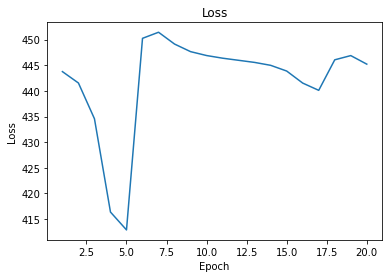

In [22]:
import matplotlib.pyplot as plt
# 損失
fig2 = plt.figure()
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(range(1, epoch+1), losses)
plt.show()
